In [1]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Advanced modelling using Catboost

In this notebook we will model the car prices using Catboost. As we've seen exploring the data, we are dealing with a dataset containing multiple categorical variables sometimes with very high cardinality (e.g model of the car) and with a high proportion of missing values.

As we saw with the base model and the linear regression we were forced to fit models on groups of cars by model and brand and sometimes registration year. The problem encountered with these methods were that for groups with very few observations we could not fit a model on the desired level of group granularity and therefore had to fit the model on  a broader group (for example a porsche 918 would have to be estimated using a regression fitted on all porsches since there weren't enough of these cars in the dataset. This lead to worse estimations for car models which are not present enough in the dataset.

Moreover, with linear regressions we were limited to using variables which displayed a somehow linear relationship with the price, however not all independent variables in our dataset have a linear relationship with the price (for example the latitude and the longitude).

Ensemble methods such as Random Forests and Gradient boosting, based on fitting regression trees are still today the leading methods for tabular datasets. Their advantage is their ability to capture complex relationships, handle categorical variables efficiently while remaining very interpretable (although gradient boosted trees aren't as interpretable as compared to random forests).

In our case gradient boosting and specifically Catboost seems like an ideal method. In fact Catboost is a gradient boosting algorithm which is tailored to datasets with sparts categorical features with high cardinality which it treats via an advanced version of target encoding (consisting of assigning the mean value of the target for each category level. It also handles missing values, treating them as a separate category.

Some of these variables might intuitively have a great influence on the price of a car (for example the extras) however simple imputation methods for these variables would affect the structure of the data. In fact for the extras the NaN value means that we do not know if the car has this extra or not and therefore these should be  treated as a separate category.



In [2]:
train = pd.read_csv('../data/train_02032024.csv',index_col=0)
test = pd.read_csv('../data/test_02032024.csv',index_col=0)

In [271]:
cols_to_drop = [x for x in train.columns if 'extra' in x]
cols_to_drop_2 = [
    'uuid',
    'label',
    'model_stub',
    'thumbs',
    'price_debatable',
    'user_id',
    'title',
    'without_vat',
    'seller',
    'created',
    'seo_json_ld',
    'address_long',
    'modified',
    'battery_range',
    'variant',
    'trim']

In [272]:
def create_groups(data):
    data['group_model_year_level'] = data['brand'] + '_' + data['model'] + '_' + data['registration_year'].astype(int).astype(str)
    data['group_model_level'] = data['brand'] + '_' + data['model']
    data['group_year_level'] = data['brand'] + '_' + data['registration_year'].astype(int).astype(str)
    return data

def drop_unwanted_columns(data):
    data = data.drop(columns = cols_to_drop + cols_to_drop_2).copy()
    return data

def split_data_to_validation(train_set):
    return train_test_split(train_set, test_size=0.2, random_state=42)

In [273]:
train, test = drop_unwanted_columns(train), drop_unwanted_columns(test)
train_val, val = split_data_to_validation(train)

# 1st Method: using our extra strategy variables with mostly all variables

In [274]:
train_val.columns

Index(['lat', 'lon', 'is_new', 'id', 'descriptive_title', 'mileage', 'crashed',
       'raw_price', 'engine_size', 'registration_month', 'registration_year',
       'engine_power', 'fuel_type', 'gearbox_type', 'brand', 'model',
       'description', 'never_crashed', 'interior_type', 'seats', 'kteo',
       'exterior_color', 'number_plate_ending', 'emissions_co2',
       'battery_charge_time', 'interior_color', 'rim_size', 'vehicle_height',
       'number_of_gears', 'torque', 'gross_weight', 'acceleration',
       'vehicle_width', 'body_type', 'vehicle_length', 'top_speed',
       'wheelbase', 'fuel_consumption', 'drive_type', 'doors', 'is_metallic',
       'comfort_options', 'safety_driver_assistance_options',
       'performance_handling_options', 'utility_options', 'premium_options',
       'infotainment_options'],
      dtype='object')

In [275]:
cols_to_drop_for_train_predict = ['id', 'descriptive_title',
       'raw_price','description']

In [276]:
train_val['fuel_consumption'] = train_val['fuel_consumption'].astype(str).str.replace(',','.').astype(float)
train_val['battery_charge_time'] = train_val['battery_charge_time']
train_val['registration_year'] = train_val['registration_year'].astype(float) #We saw the ordinal relationship of year with the price so we will treat is as a numerical variable


In [277]:
val['fuel_consumption'] = val['fuel_consumption'].astype(str).str.replace(',','.').astype(float)
val['acceleration'] = val['acceleration'].astype(str).str.replace(',','.').astype(float)
val['battery_charge_time'] = val['battery_charge_time']
val['registration_year'] = val['registration_year'].astype(float) #We saw the ordinal relationship of year with the price so we will treat is as a numerical variable


In [278]:
numerical_features = train_val.drop(columns=cols_to_drop_for_train_predict).select_dtypes(include=['float']).columns.tolist()

In [279]:
categorical_features = train_val.drop(columns=cols_to_drop_for_train_predict).select_dtypes(include=['object','category','int','bool']).columns.tolist()

In [280]:
categorical_features

['is_new',
 'crashed',
 'registration_month',
 'fuel_type',
 'gearbox_type',
 'brand',
 'model',
 'never_crashed',
 'interior_type',
 'kteo',
 'exterior_color',
 'number_plate_ending',
 'interior_color',
 'body_type',
 'drive_type',
 'is_metallic']

In [281]:
numerical_features

['lat',
 'lon',
 'mileage',
 'engine_size',
 'registration_year',
 'engine_power',
 'seats',
 'emissions_co2',
 'battery_charge_time',
 'rim_size',
 'vehicle_height',
 'number_of_gears',
 'torque',
 'gross_weight',
 'acceleration',
 'vehicle_width',
 'vehicle_length',
 'top_speed',
 'wheelbase',
 'fuel_consumption',
 'doors',
 'comfort_options',
 'safety_driver_assistance_options',
 'performance_handling_options',
 'utility_options',
 'premium_options',
 'infotainment_options']

In [282]:
cols_for_predict = train.drop(columns=cols_to_drop_for_train_predict).columns.tolist()

In [283]:
X_val = train_val.drop(columns=cols_to_drop_for_train_predict)

In [284]:
X_test_val = val.drop(columns=cols_to_drop_for_train_predict)

In [285]:
cols_for_predict = [X_val.columns.get_loc(x) for x in cols_for_predict]
numerical_features = [X_val.columns.get_loc(x) for x in numerical_features]
categorical_features = [X_val.columns.get_loc(x) for x in categorical_features]

In [286]:
X_val.iloc[:,categorical_features] = X_val.iloc[:,categorical_features].fillna("nan")

In [287]:
X_test_val.iloc[:,categorical_features] = X_test_val.iloc[:,categorical_features].fillna("nan")

In [288]:
scaler = StandardScaler()
X_val.iloc[:,numerical_features] = scaler.fit_transform(X_val.iloc[:,numerical_features])

In [289]:
X_test_val.iloc[:,numerical_features] = scaler.transform(X_test_val.iloc[:,numerical_features])

In [318]:
target_scale = StandardScaler()

In [329]:
train_val_set = Pool(data = X_val , cat_features = categorical_features, label= target_scale.fit_transform(train_val.raw_price.to_numpy().reshape(-1,1)))

In [330]:
test_val_set = Pool(data = X_test_val , cat_features = categorical_features, label= target_scale.transform(val.raw_price.to_numpy().reshape(-1,1)))

In [331]:
catboost = CatBoostRegressor(loss_function='MAE', iterations=771, learning_rate=0.1, max_depth=8 , nan_mode='Max')

In [332]:
catboost.fit(train_val_set,eval_set=test_val_set, early_stopping_rounds=100, verbose=100)


0:	learn: 0.4547267	test: 0.4627367	best: 0.4627367 (0)	total: 49.7ms	remaining: 38.3s
100:	learn: 0.1332508	test: 0.1401145	best: 0.1401145 (100)	total: 4.62s	remaining: 30.6s
200:	learn: 0.1165704	test: 0.1261103	best: 0.1261103 (200)	total: 9.27s	remaining: 26.3s
300:	learn: 0.1087658	test: 0.1209786	best: 0.1209786 (300)	total: 14.1s	remaining: 22.1s
400:	learn: 0.1039390	test: 0.1189790	best: 0.1189780 (399)	total: 19.2s	remaining: 17.7s
500:	learn: 0.1006374	test: 0.1178146	best: 0.1178146 (500)	total: 24.3s	remaining: 13.1s
600:	learn: 0.0977865	test: 0.1172279	best: 0.1172279 (600)	total: 30s	remaining: 8.49s
700:	learn: 0.0956795	test: 0.1167841	best: 0.1167841 (700)	total: 35.7s	remaining: 3.56s
770:	learn: 0.0943619	test: 0.1164755	best: 0.1164755 (770)	total: 39.7s	remaining: 0us

bestTest = 0.1164754928
bestIteration = 770



In [333]:
predictions = catboost.predict(test_val_set)

In [334]:
pd.DataFrame({'features' : X_val.columns, 'importance': catboost.get_feature_importance()}).sort_values(by='importance',ascending=False)

,features,importance
8,engine_power,26.917452
7,registration_year,17.551720
5,engine_size,14.871042
11,brand,11.197254
3,mileage,5.407457
12,model,2.739625
34,drive_type,2.386114
9,fuel_type,2.354948
10,gearbox_type,2.307631
15,seats,1.790204


In [335]:
results = val.copy()

In [343]:
results['prediction'] = target_scale.inverse_transform(predictions.reshape(-1,1))
results['residuals'] = results['raw_price'] - predictions
results['abs_residuals'] = abs(results['raw_price'] - predictions)
results['ape'] = abs(results['raw_price'] - predictions)/results['raw_price']

In [344]:
results.ape.mean()

1.000050339283962

In [208]:
results.ape.describe([0.01,0.05,0.1,0.25,0.5,0.75,0.90,0.95,0.975,0.99])

count    16229.000000
mean         0.155796
std          0.483404
min          0.000025
1%           0.001576
5%           0.007749
10%          0.016248
25%          0.042763
50%          0.093760
75%          0.179917
90%          0.314312
95%          0.449692
97.5%        0.646842
99%          1.001718
max         52.714387
Name: ape, dtype: float64

In [209]:
results.abs_residuals.describe([0.01,0.05,0.1,0.25,0.5,0.75,0.90,0.95,0.975,0.99])

count     16229.000000
mean       2149.266164
std        5245.577890
min           0.126210
1%           16.184321
5%           83.994402
10%         173.259304
25%         433.386389
50%         986.953561
75%        2069.337839
90%        4307.369713
95%        7113.583979
97.5%     11241.384979
99%       20746.112651
max      160946.231104
Name: abs_residuals, dtype: float64

(0.0, 250000.0)

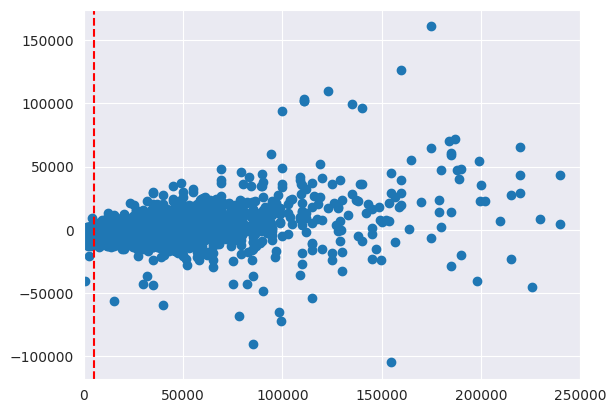

In [243]:
from matplotlib import pyplot as plt

plt.scatter(results.raw_price, results.residuals)
plt.axvline(5000,color='r',linestyle='--')
plt.xlim([0,250000])

(-10000.0, 10000.0)

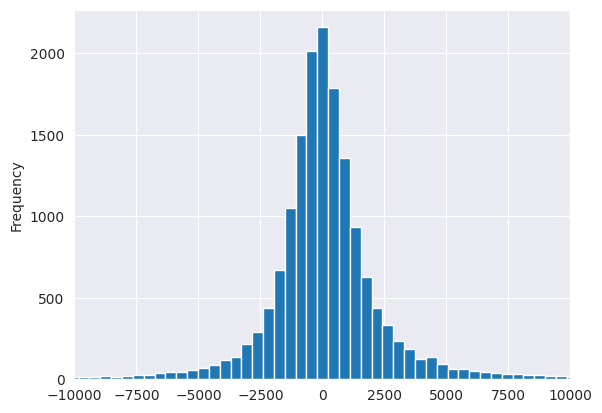

In [184]:
results.residuals.plot(kind='hist',bins=500, )
plt.xlim([-10000,10000])

In [212]:
results.loc[:,['brand','ape']].groupby('brand').agg('median').sort_values(by='ape',ascending=False)

,ape
brand,
chrysler,1.065709
corvette,0.831211
mclaren,0.678006
aston martin,0.459718
ecocar,0.422333
...,...
peugeot,0.075869
renault,0.074856
nissan,0.073459


In [218]:
brand_counts = train.brand.value_counts()
results['brand_counts'] = results['brand'].map(brand_counts)

(0.0, 1.0)

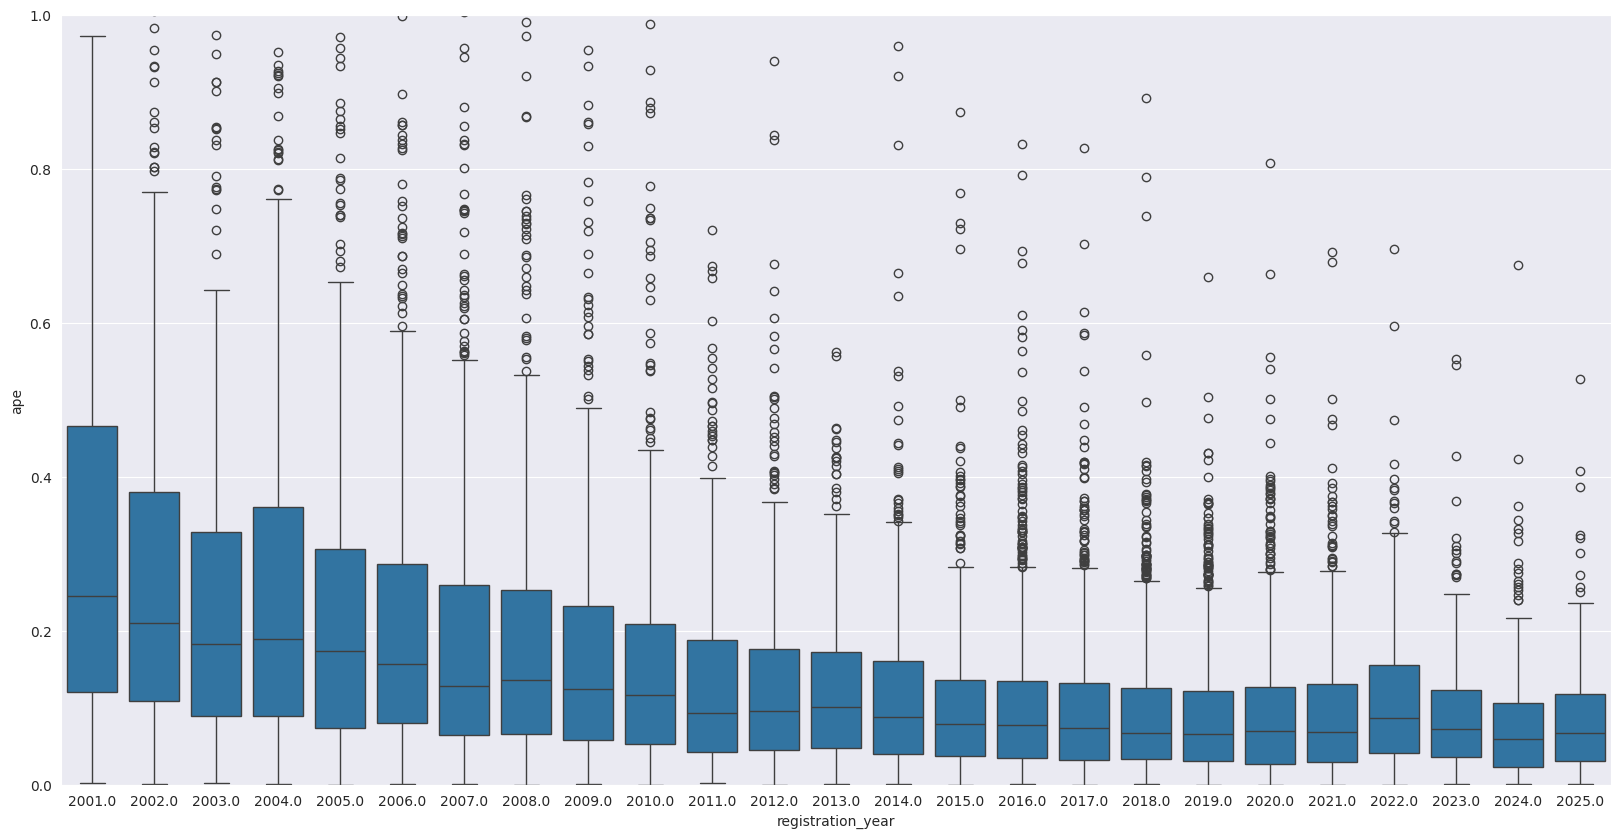

In [227]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.boxplot(x = results.registration_year, y= results.ape)
plt.ylim([0,1])

In [235]:
results.loc[:,['registration_year','ape']].groupby('registration_year')['ape'].apply(lambda x : x.describe([0.9,0.95])).unstack(0)

registration_year,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,...,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0,2024.0,2025.0
count,312.000000,383.000000,430.000000,553.000000,570.000000,645.000000,750.000000,726.000000,672.000000,458.000000,...,1305.000000,1223.000000,1180.000000,1250.000000,916.000000,673.000000,308.000000,273.000000,268.000000,170.000000
mean,0.419694,0.351504,0.283500,0.307741,0.247085,0.228407,0.202196,0.215037,0.178915,0.169067,...,0.102212,0.097709,0.095358,0.088054,0.094919,0.109127,0.118242,0.094447,0.274809,0.086795
std,0.706558,0.573854,0.370802,0.413614,0.290927,0.258455,0.249316,0.324579,0.212171,0.191463,...,0.111730,0.101829,0.141483,0.078986,0.110335,0.316278,0.139236,0.084582,3.216318,0.082706
min,0.001521,0.001141,0.002478,0.001127,0.000032,0.000421,0.000398,0.000028,0.000512,0.000096,...,0.000182,0.000081,0.000153,0.000031,0.000032,0.000060,0.000066,0.000135,0.000269,0.000492
50%,0.244275,0.209533,0.183026,0.189354,0.173132,0.156665,0.128368,0.135738,0.123607,0.116279,...,0.077392,0.073926,0.066779,0.065399,0.068977,0.068539,0.085836,0.072047,0.059231,0.066687
90%,0.803594,0.693503,0.587089,0.635129,0.501234,0.485035,0.430349,0.436266,0.363474,0.370261,...,0.208475,0.199495,0.200659,0.191906,0.207278,0.206603,0.242009,0.197547,0.172207,0.179319
95%,1.183777,0.979773,0.879904,0.924938,0.754411,0.705526,0.573330,0.629015,0.494899,0.539357,...,0.282774,0.269922,0.267769,0.251821,0.276723,0.269123,0.323612,0.256727,0.255320,0.243231
max,8.368516,6.253504,4.143100,4.188325,2.571015,2.344392,3.741592,4.539648,2.482249,1.481434,...,1.789500,1.452768,3.900502,0.659539,1.963120,6.672949,1.794308,0.552378,52.714387,0.526573


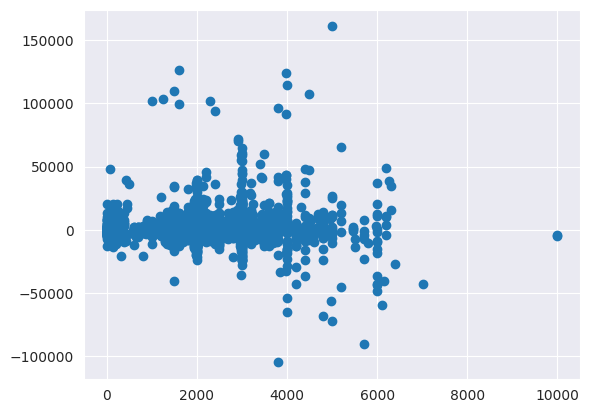

In [241]:
plt.scatter(results.engine_size, results.residuals)


In [247]:
results['pe'] = results.residuals/results.raw_price

(-10.0, 10.0)

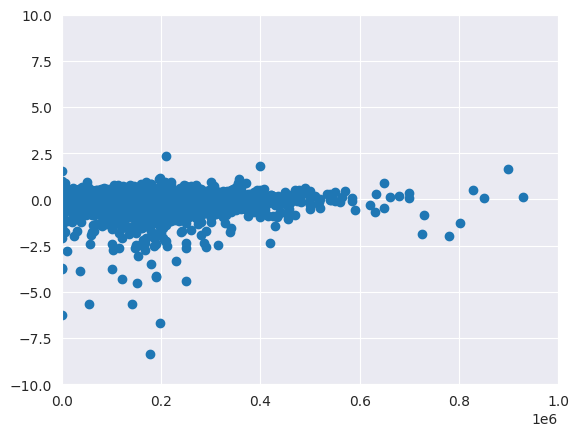

In [250]:
plt.scatter(results.mileage, results.pe)
plt.xlim([0,1000000])
plt.ylim([-10,10])


(0.0, 10000.0)

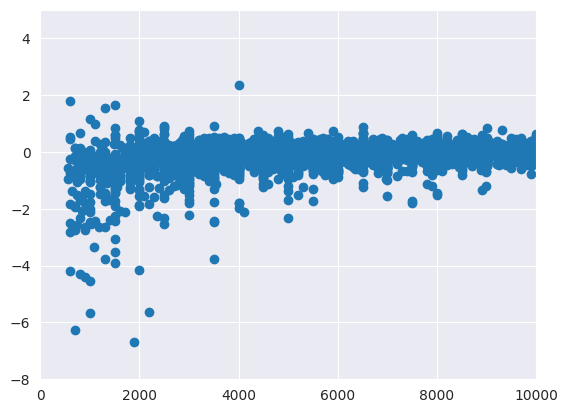

In [254]:
plt.scatter(results.raw_price,results.pe) #raw_price - pred
plt.ylim([-8,5])
plt.xlim([0,10000])

(0.0, 1.0)

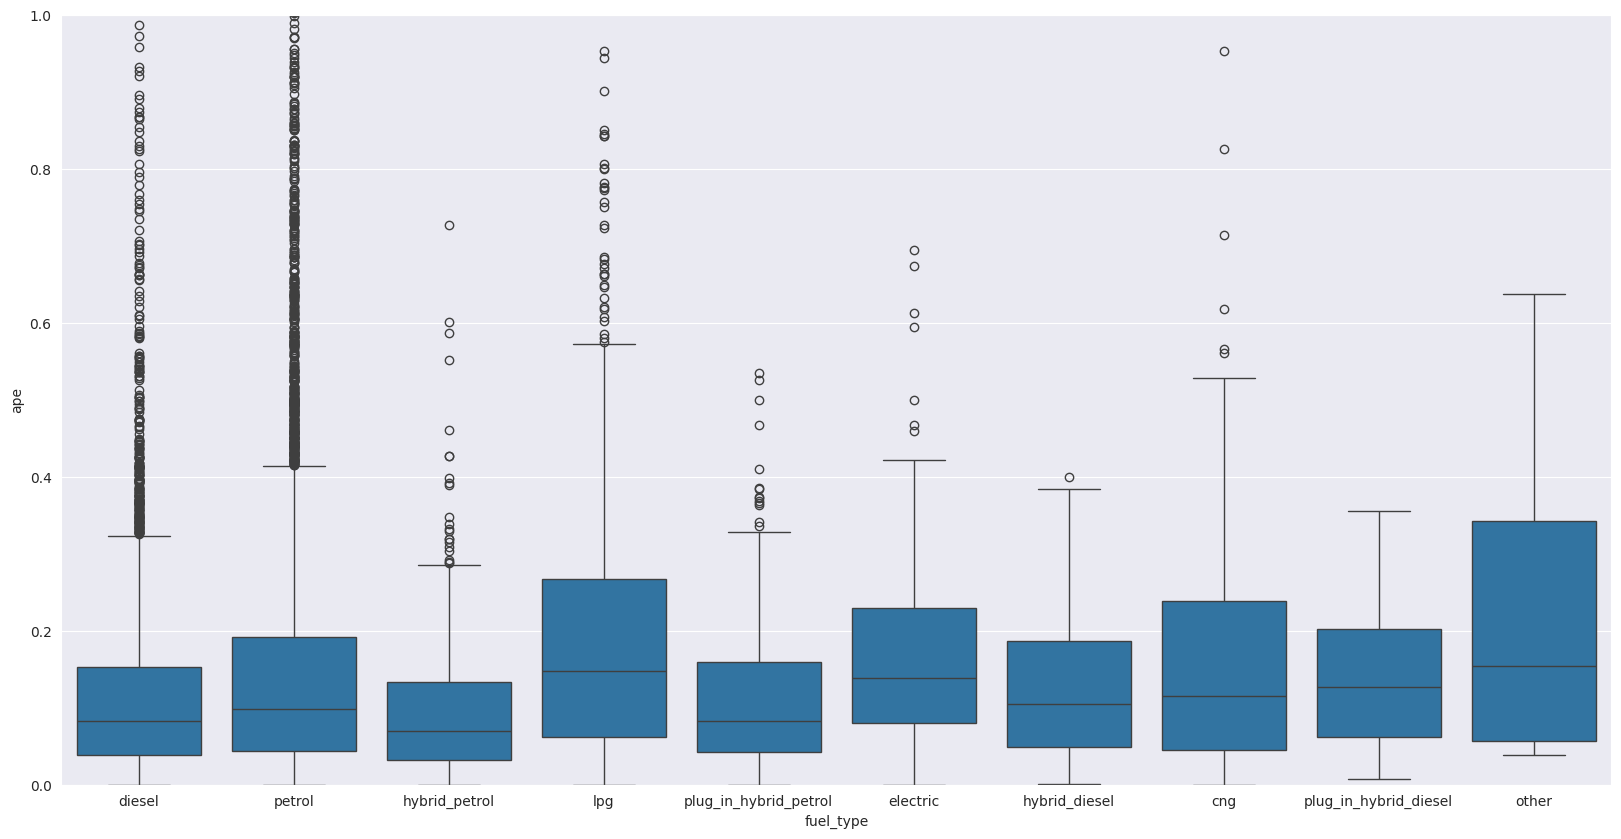

In [258]:
plt.figure(figsize=(20,10))
sns.boxplot(x= results.fuel_type, y=results.ape)
plt.ylim([0,1])